# Bibliotecas e download do dataset

In [1]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.optimizers import Adam
from sklearn.metrics
import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
from keras.models import Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.regularizers import l2
from keras.applications import InceptionV3
from keras.callbacks import ModelCheckpoint, EarlyStopping
import zipfile
from PIL import Image

In [2]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [04:05<00:00, 23.1MB/s]
100% 5.20G/5.20G [04:05<00:00, 22.8MB/s]


In [3]:

zip_ref = zipfile.ZipFile('/content/skin-cancer-mnist-ham10000.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Tratamento do Dataset

In [4]:
df = pd.read_csv('/content/hmnist_28_28_RGB.csv')

y = df['label']
x = df.drop(columns = ['label'])

In [5]:
oversample = RandomOverSampler()# oversampler para remediar o problema da quantidade desigual de nevos no dataset
x, y = oversample.fit_resample(x, y)
y = y.reset_index(drop=True)

In [6]:
x = x.values
y = y.values
x = x.reshape(-1, 28, 28, 3)
x= x.astype('float32') / 255.0

X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=42)

X_train = tf.image.resize(X_train, (75, 75))
X_test = tf.image.resize(X_test, (75, 75))

# Definição do modelo

In [139]:

inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
inceptionv3.trainable = False

In [140]:

model = Sequential()

model.add(inceptionv3)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

In [141]:
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [142]:

checkpoint = ModelCheckpoint(
    filepath = '/content/modelo.keras',
    monitor ='val_sparse_categorical_accuracy',
    verbose = True,
    save_best_only = True,
    save_weights_only=False,
    mode = 'max'
)
callback = EarlyStopping(monitor = 'val_loss', patience = 4)


In [144]:
hist = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test), callbacks=[checkpoint, callback], verbose = 1)

Epoch 1/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0392 - sparse_categorical_accuracy: 0.6292
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.86439, saving model to /content/modelo.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 60s 45ms/step - loss: 1.0389 - sparse_categorical_accuracy: 0.6293 - val_loss: 0.3712 - val_sparse_categorical_accuracy: 0.8644
Epoch 2/10
1173/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2983 - sparse_categorical_accuracy: 0.8959
Epoch 2: val_sparse_categorical_accuracy improved from 0.86439 to 0.92191, saving model to /content/modelo.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 55s 25ms/step - loss: 0.2982 - sparse_categorical_accuracy: 0.8959 - val_loss: 0.2255 - val_sparse_categorical_accuracy: 0.9219
Epoch 3/10
1173/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1721 - sparse_categorical_accuracy: 0.9406
Epoch 3: val_sparse_categorical_accuracy improved from 0.92191 to 0.94428, saving model to /content/modelo.keras
1174/1174 ━━━━━━━━━━━━

# Métricas e matriz de confusão

In [145]:

acc_treino= max(hist.history['sparse_categorical_accuracy'])
acc_val = max(hist.history['val_sparse_categorical_accuracy'])

print(f'Acurácia Treino : {acc_treino}')
print(f'Acurácia Validação : {acc_val}')


Acurácia Treino : 0.9831149578094482
Acurácia Validação : 0.9735804796218872


In [147]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, average='weighted')# weighted por conta do dataset desbalanceado anteriormente
recall = recall_score(Y_test, y_pred, average='weighted')
print(f'Precisão: {precision}')
print(f'Recall: {recall}')
print(f'Acurácia: {accuracy}')

294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


TypeError: 'numpy.float64' object is not callable

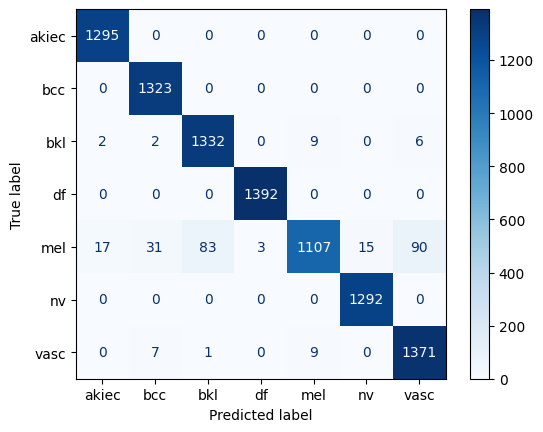

In [148]:

classes = {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5:'nv', 6: 'vasc'}
matriz = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes.values())
disp.plot(cmap=plt.cm.Blues)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


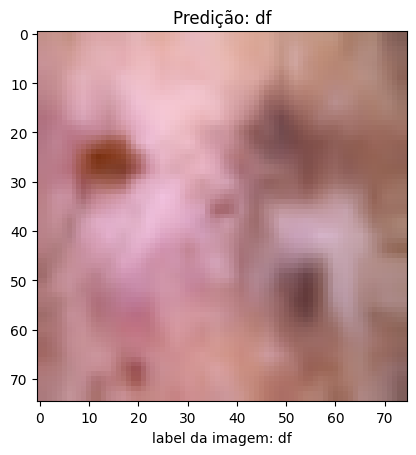

In [149]:
x=43
prev =model.predict(np.expand_dims(X_test[x], axis=0))
predicted_class = tf.argmax(prev, axis=1).numpy()[0]
plt.title(f'Predição: {classes[predicted_class]}')
plt.text(0.5, -0.1,f'label da imagem: {classes[Y_test[x]]}', ha='center', va='center', transform=plt.gca().transAxes)
plt.imshow(X_test[x])# testes em uma imagem do dataset

# Testes com imagens obtidas em laboratório

In [150]:
img_dir = '/content/imagens laboratorio/'
imagens = []
for file_name in os.listdir(img_dir):
    image_path = os.path.join(img_dir, file_name)

    img = Image.open(image_path)
    img = img.resize((75, 75))
    img_array = np.array(img) / 255.0  #
    img_array = img_array.astype('float32')

    imagens.append(img_array)
imagens = np.array(imagens).astype('float32') # tratamento de imagens fora do dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


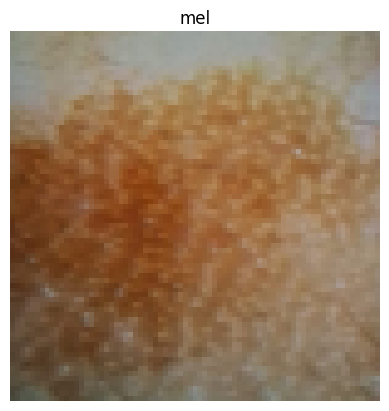

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


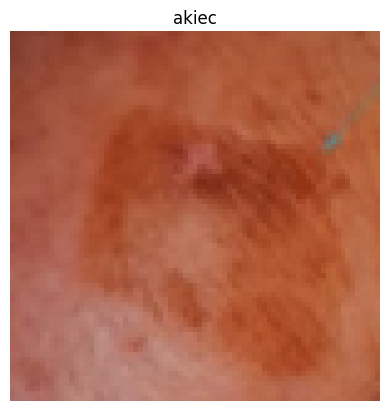

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


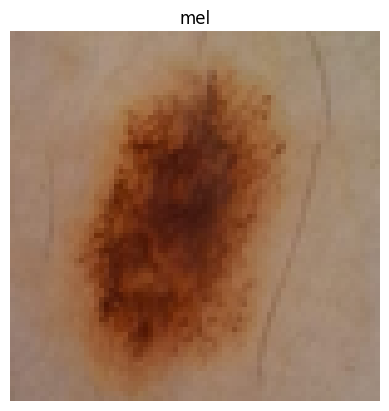

In [151]:
for img in imagens:
  imagem = np.expand_dims(img, axis=0)
  prev = model.predict(imagem)
  prev_classe = np.argmax(prev, axis=1)[0]
  plt.title(classes[prev_classe])
  plt.imshow(img)
  plt.axis('off')
  plt.show()
# predição realizada nas imagens de fora do dataset